In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
import wandb
from datasets import load_metric, Dataset
from IPython.display import Markdown, display
from IPython.core.debugger import set_trace

from datasets import load_dataset
from lexicalrichness import LexicalRichness
import functools
import string
import psutil
from collections import defaultdict
from spacy_wordnet.wordnet_annotator import WordnetAnnotator 
import operator
import spacy
import textstat
import difflib as dl
from itertools import groupby
from operator import itemgetter

In [13]:
seed = 420
np.random.seed(seed)
run_name = "mild-jazz-178"
wandb_run_path = "uts_nlp/travis_attack/36206pkc"  # get this from wandb overview section 

# Init W&B run object
api = wandb.Api()
run = api.run(wandb_run_path)
config = run.config

# Init spacy model and other global nlp things
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(WordnetAnnotator(nlp.lang), after='tagger')
rouge_metric = load_metric("rouge")

# Load CSV files
path_results = f"../model_checkpoints/travis_attack/{run_name}/"
train            = pd.read_csv(path_results + "train.csv")
valid            = pd.read_csv(path_results + "valid.csv")
test             = pd.read_csv(path_results + "test.csv")
training_step    = pd.read_csv(path_results + "training_step.csv")
training_summary = pd.read_csv(path_results + "training_summary.csv")

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            with pd.option_context("max_colwidth", 480):
                display(df) 

## General run information 

In [5]:
## Some markdown below 
Markdown(f"""
### Summary 

**Dataset**: {config['dataset_name']}  
**Paraphrase model**: `{config['pp_name']}`  
**Victim model**: `{config['vm_name']}`  
**Semantic Textual Similarity model**: `{config['sts_name']}`  
**Number of epochs**: {config['n_train_epochs']}  
**Reward function**: `{config['reward_strategy']}`  
**Using the full dataset**: {True if not config['use_small_ds'] else f"False: n_shards set to {config['shard_params']['n_shards']} shards with shard_contiguous set to {config['shard_params']['shard_contiguous']}"}   
We freeze all layers of the paraphrase model except the last **{config['n_layers_frozen']}** layers.  
We eval every **{config['eval_freq']}** epochs.   

### Paraphrase parameters 
**Decoding strategy**: {config['sampling_strategy']}  
**Number of beams**: {config['pp_model_params']['num_beams']}  
**Number of return sequences**: {config['pp_model_params']['num_return_sequences']}  
**Max length**: {config['pp_model_params']['max_length']}  
**Min length**: {config['pp_model_params']['min_length']}  
**Temperature**: {config['pp_model_params']['temperature']}  
**Length penalty**: {config['pp_model_params']['length_penalty']}  
**Number of beam groups**: {config['pp_model_params']['num_beam_groups']}  
**Diversity penalty**: {config['pp_model_params']['diversity_penalty']}  

  
### Run parameters
**Seed**: {config['seed']}  
**Learning rate**: {config['lr']}  
**Batch sizes:** Train: {config['batch_size_train']}, Eval: {config['batch_size_eval']}  
**Max number of tokens in input**: {config['max_length']}  
**Remove initially misclassified examples**: {config['remove_misclassified_examples']}  
**Input bucketed by length:** {config['bucket_by_length']}  
**Shuffle training data:** {config['shuffle_train']}  
**Pad input data to multiple of**: {config['padding_multiple']}  
**Pad embedding matrices**: {config['pad_token_embeddings']}  
**Normalise rewards?**: {config['normalise_rewards']}  
**Gradient accumulation?**: {False if config['accumulation_steps'] == 1  else f"Every {config['accumulation_steps']} steps"}  

### Low-level parameters 
**Use fp16 for training?**: {config['fp16']}  
**Use memory pinning with dataloaders?**: {config['pin_memory']}  
**Initilise gradients with `None` when running `zero_grad()`**: {config['zero_grad_with_none']}  
""")


### Summary 

**Dataset**: rotten_tomatoes  
**Paraphrase model**: `eugenesiow/bart-paraphrase`  
**Victim model**: `textattack/distilbert-base-uncased-rotten-tomatoes`  
**Semantic Textual Similarity model**: `sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2`  
**Number of epochs**: 30  
**Reward function**: `[-0.5 if sts < 0.5 else 0.5+v*sts for v,sts in zip(vm_scores, sts_scores)]`  
**Using the full dataset**: True   
We freeze all layers of the paraphrase model except the last **2** layers.  
We eval every **1** epochs.   

### Paraphrase parameters 
**Decoding strategy**: greedy  
**Number of beams**: 1  
**Number of return sequences**: 1  
**Max length**: 64  
**Min length**: 5  
**Temperature**: 1.5  
**Length penalty**: 1  
**Number of beam groups**: 1  
**Diversity penalty**: 0  

  
### Run parameters
**Seed**: 420  
**Learning rate**: 3e-05  
**Batch sizes:** Train: 32, Eval: 128  
**Max number of tokens in input**: 64  
**Remove initially misclassified examples**: True  
**Input bucketed by length:** True  
**Shuffle training data:** False  
**Pad input data to multiple of**: 8  
**Pad embedding matrices**: True  
**Normalise rewards?**: False  
**Gradient accumulation?**: False  

### Low-level parameters 
**Use fp16 for training?**: True  
**Use memory pinning with dataloaders?**: True  
**Initilise gradients with `None` when running `zero_grad()`**: False  


## Training summary 

In [6]:
## Some markdown below
Markdown(f"""For this one go to the [dashboard](https://wandb.ai/{wandb_run_path}) and have a look at it manually""")

For this one go to the [dashboard](https://wandb.ai/uts_nlp/travis_attack/36206pkc) and have a look at it manually

## Dataset-level stats

In [7]:
df = training_step  # can set to train, valid or test (and maybe training_step)
df = df.sort_values(by=['idx', "epoch"], axis=0)
df = df.query("idx <= 300")  # just for testing purposes
# Getting weird behaviour with group_by's so binning some of the numeric values
df['sts_score'] = df['sts_score'].round(4) 
df['vm_score'] = df['vm_score'].round(4) 
df['reward'] = df['reward'].round(4) 
df['pp_truelabel_probs'] = df['pp_truelabel_probs'].round(4) 

#display_all(df)

Fraction of examples with more than one paraphrase tried: 0.623
Fraction of examples with a label flip at some point: 0.09799999999999998


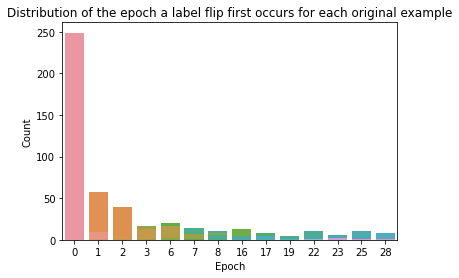

In [8]:
def add_number_of_unique_pps_per_idx(df): 
    df_grp = df.groupby("idx").agg({"pp_l":"nunique"})
    df_grp= df_grp.rename(columns = {"pp_l":"idx_n_unique_pp"})
    # plot histogram
    fig = sns.countplot(x='idx_n_unique_pp', data=df_grp) 
    plt.title("Distribution of the number of unique paraphrases per original example")
    plt.xlabel("Unique paraphrases")
    plt.ylabel("Count") 
    # Add column to orig df and return 
    df = df.merge(df_grp, left_on='idx', right_index=True, how='left')
    return df

df = add_number_of_unique_pps_per_idx(df)
# some summary statistics 
counts = df[['idx','idx_n_unique_pp']].drop_duplicates()['idx_n_unique_pp'].value_counts()
print(f"Fraction of examples with more than one paraphrase tried: {1 - (counts.iloc[0]/sum(counts)).round(3)}")

def add_number_of_pp_changes_per_idx(df): 
    df['pp_changed'] = df.sort_values(["idx","epoch"]).groupby('idx')['pp_l'].shift().ne(df['pp_l']).astype(int)
    df_grp = df.groupby('idx').agg({'pp_changed': 'sum'})
    df_grp= df_grp.rename(columns = {"pp_changed":"idx_n_pp_changes"})
    df_grp['idx_n_pp_changes'] -= 1  # The first paraphrase isn't a change
    df = df.drop('pp_changed', 1) # don't need this anymore 
    
    # Plot histogram
    fig = sns.countplot(x='idx_n_pp_changes', data=df_grp) 
    plt.title("Distribution of the number of paraphrase changes during training per original example")
    plt.xlabel("Paraphrase changes")
    plt.ylabel("Count")
    
    # Add column to orig df before returning 
    df = df.merge(df_grp, left_on='idx', right_index=True, how='left')
    return df 
df = add_number_of_pp_changes_per_idx(df)

def add_epoch_of_first_label_flip(df): 
    rownum_of_first_flip = df.groupby('idx')[['epoch','label_flip']].idxmax()['label_flip']
    ## idxmax returns first max
    df_grp = df[['idx','epoch']].loc[rownum_of_first_flip]
    df_grp= df_grp.rename(columns = {"epoch":"epoch_of_first_label_flip"})
    fig = sns.countplot(x='epoch_of_first_label_flip', data=df_grp)
    plt.title("Distribution of the epoch a label flip first occurs for each original example")
    plt.xlabel("Epoch")
    plt.ylabel("Count")
    df = df.merge(df_grp, left_on='idx', right_on='idx', how='left')
    return df
df = add_epoch_of_first_label_flip(df)
# some summary statistics 
counts = df[['idx','epoch_of_first_label_flip']].drop_duplicates()['epoch_of_first_label_flip'].value_counts()
print(f"Fraction of examples with a label flip at some point: {1 - (counts.iloc[0]/sum(counts)).round(3)}")


In [9]:
# Sampling some low sts score examples 
#display_all(df.query('sts_score < 0.7').sort_values('sts_score').sample(10)[['orig_l','pp_l','sts_score']])

### Text stats 

In [10]:
def get_added_end_of_sentence_phrase(orig, pp): 
    if len(pp) > len(orig): 
        rep = pp.replace(orig, "")
        if rep != pp: return rep 
    return ""

def get_removals_insertions_unchanged_phrases(orig, pp): 
    orig_t = [token.text for token in nlp(orig)]
    pp_t = [token.text for token in nlp(pp)]
    diff = [x for x in dl.ndiff(orig_t, pp_t)]
    d = defaultdict(lambda: [])
    
    def get_subsequences(sign): 
        if   sign == "insertions": op = "+"
        elif sign == "removals":   op = "-"
        elif sign == "unchanged":  op = " "
        else: raise Exception("shouldn't get here")
        idx,words = [],[]
        for i, o in enumerate(diff): 
            if o[0] == op: 
                idx.append(i)
                words.append(o[2:])
        # Group words that go together        
        word_groups = []
        # bit of a mystery this bit but seems to work. just need 1-1 mapping between data and words 
        for k, g in groupby(zip(enumerate(idx), words), lambda ix: ix[0][0] - ix[0][1]):
            word_groups.append(list(map(itemgetter(1), g)))
            
        def join_punctuation(seq, characters=set(string.punctuation)):
            "handle "
            seq = iter(seq)
            current = next(seq)
            for nxt in seq:
                if nxt in characters:
                    current += nxt
                else:
                    yield current
                    current = nxt
            yield current

        phrases = [' '.join(join_punctuation(l)) for l in word_groups]
        return idx, words, word_groups, phrases
    
    insertions_idx,_,_,insertions = get_subsequences("insertions")
    removals_idx,_,_,removals   = get_subsequences("removals")
    unchanged_idx,_,_,unchanged = get_subsequences("unchanged")
    def is_truncation(unchanged_idx, removals_idx):
        if len(removals_idx) == 0 or len(unchanged_idx) == 0 : return False 
        if max(unchanged_idx) < max(removals_idx): return True 
        else: return False
    
    return {'removals_idx': removals_idx, 
            'removals': removals,
            'is_truncation': is_truncation(unchanged_idx, removals_idx),
            'insertions_idx': insertions_idx,
            'insertions': insertions, 
            'unchanged_idx': unchanged_idx,
            'unchanged': unchanged}

In [15]:
def get_text_metrics(text):
    def get_chartype_count(text, strset=string.ascii_letters):
        return len(list(filter(functools.partial(operator.contains, strset), text)))     
    d = defaultdict(lambda: 0)
    ### Spacy stuff
    doc = nlp(text)
    # Which tags to keep
    # see  https://universaldependencies.org/docs/u/pos/
    UPOS_tags = ['ADJ','ADP','ADV','AUX','CONJ','DET','INTJ','NOUN',
     'NUM','PART','PRON','PROPN','PUNCT','SCONJ',
     'SYM','VERB','X']
    d_POS = defaultdict(lambda: 0)  # d_POS holds parts of speech
    d['n_nonzero_synsets'] = 0  # fix something weird with datasets.map code?
    for token in doc:
        n_synsets = len(token._.wordnet.synsets())
        n_lemmas = len(token._.wordnet.lemmas())
        d['n_total_synsets'] += n_synsets; 
        d['n_total_lemmas'] += n_lemmas
        if n_synsets > 0: d['n_nonzero_synsets'] += 1 
        d_POS[token.pos_] += 1

    d['n_tokens'] = max(len(doc), 1)  # handle empty string 
    d['avg_synsets'] = d['n_total_synsets'] / d['n_tokens']
    d['avg_lemmas']  = d['n_total_lemmas']  / d['n_tokens']     
    for tag in UPOS_tags: d['n_upos_tag_' + tag] = d_POS[tag]

    ### Lexical stuff
    lex = LexicalRichness(text)    
    d['n_words'] = lex.words
    d['n_stopwords'] = sum([token.is_stop for token in doc])
    d['n_named_entities'] = len(doc.ents)
    d['n_unique_words'] = lex.terms
    d['n_punctuation'] = get_chartype_count(text, strset=string.punctuation)
    d['n_digits'] = get_chartype_count(text, strset=string.digits)
    d['n_letters'] = get_chartype_count(text, strset=string.ascii_letters)
    d['MTLD'] = lex.mtld(threshold=0.72) if lex.words > 1 else 0.0 
    d['HDD'] = lex.hdd(draws=min(lex.words, 30)) if lex.words > 1 else 0.0 
    d['Maas'] = lex.Maas if lex.words > 1 else 0.0 

    ### Textstat stuff
    d['flesch_kincaid_ease']      = textstat.flesch_reading_ease(text)
    d['SMOG']                     = textstat.smog_index(text)
    d['gunning_fog']              = textstat.gunning_fog(text)
    d['difficult_words']          = textstat.difficult_words(text)
    d['dale_chall']               = textstat.dale_chall_readability_score(text)
    d['ARI']                      = textstat.automated_readability_index(text)
    d['coleman_liau']             = textstat.coleman_liau_index(text)
    d['linsear_write']            = textstat.linsear_write_formula(text)
    d['readability_consensus']    = textstat.text_standard(text, float_output=True)
    #d['avg_sentence_length']      = textstat.avg_sentence_length(text)
    return d

def get_text_pair_metrics(orig, pp): 
    def get_rouge_score(ref, pred):
        return rouge_metric.compute(rouge_types=["rougeL"], predictions=[pred], references=[ref])['rougeL'].mid.fmeasure 
    d = dict()
    d['rouge_score'] = get_rouge_score(ref=orig, pred=pp)
    #d['added_eos_phrase'] = get_added_end_of_sentence_phrase(orig, pp)
    d1 = get_removals_insertions_unchanged_phrases(orig, pp)
    d = {**d, **d1}  # merge two dicts
    return d

def get_text_metrics_for_ds(ds, colname, suffix, num_proc):
    """returns a df"""
    # num_proc=8 seems pretty good - diminishing returns and we may as well leave some CPU for others 
    x = ds.map(get_text_metrics, input_columns = [colname], batched=False, 
               num_proc = num_proc )
    # rename columns
    colnames_mapping = dict()
    for k in x.column_names: colnames_mapping[k] = k + f"_{suffix}" if k != colname else k
    x = x.rename_columns(colnames_mapping)
    return pd.DataFrame(x)

def get_text_pair_metrics_for_ds(ds, num_proc): 
    x = ds.map(get_text_pair_metrics, input_columns = ["orig_l", "pp_l"], batched=False, 
               num_proc = num_proc )
    return pd.DataFrame(x)

In [16]:
def add_text_stats(df):
    # Go through all original examples, calculate stats, then join back to main df  
    #num_proc = min(8, psutil.cpu_count())
    num_proc=1  # for testing
    ds_orig = Dataset.from_pandas(df['orig_l'].drop_duplicates().to_frame())
    print("\n#### Calculating text statistics for the original examples. ####\n")
    df_orig = get_text_metrics_for_ds(ds_orig, colname="orig_l", suffix="orig", num_proc=num_proc)    
    df = pd.merge(df, df_orig, how='left', on=['orig_l'])
    
    # Go through all paraphrases, calculate stats, then join back to main df   
    ds_pp = Dataset.from_pandas(df['pp_l'].drop_duplicates().to_frame())
    print("\n#### Calculating text statistics for paraphrases. ####\n")
    df_pp = get_text_metrics_for_ds(ds_pp, colname="pp_l", suffix="pp", num_proc=num_proc)    
    df = pd.merge(df, df_pp, how='left', on=['pp_l'])
    
    ## Calculate differences in stats
    keys = get_text_metrics("some text here").keys()
    for k in keys:  df[f"{k}_diff"] = df[f"{k}_orig"] - df[f"{k}_pp"]
    
    ## Calc stats for (orig, pp) unique pairs
    ds_pairs = Dataset.from_pandas(df[['orig_l','pp_l']].drop_duplicates())
    print("\n#### Calculating text pair statistics ####\n")
    df_pairs = get_text_pair_metrics_for_ds(ds_pairs, num_proc=num_proc)
    df = pd.merge(df, df_pairs, how='left', on=['orig_l','pp_l'])    
    return df 


df = add_text_stats(df)


#### Calculating text statistics for the original examples. ####



  0%|          | 0/276 [00:00<?, ?ex/s]


#### Calculating text statistics for paraphrases. ####



  0%|          | 0/815 [00:00<?, ?ex/s]


#### Calculating text pair statistics ####



  0%|          | 0/815 [00:00<?, ?ex/s]

In [20]:
display_all(df[['orig_l', 'pp_l','removals','insertions','unchanged',  'is_truncation']].sample(10))

,orig_l,pp_l,removals,insertions,unchanged,is_truncation
4613,"for a good chunk of its running time , trapped is an effective and claustrophobic thriller .","For a good chunk of its running time, trapped is an effective and claustrophobic thriller.",[for],[For],"[a good chunk of its running time, trapped is an effective and claustrophobic thriller.]",False
5013,a cop story that understands the medium amazingly well .,A cop story that understands the medium amazingly well.,[a],[A],[cop story that understands the medium amazingly well.],False
6495,"the passions aroused by the discord between old and new cultures are set against the strange , stark beauty of the mideast desert , so lovingly and perceptively filmed that you can almost taste the desiccated air .","The passions aroused by the discord between old and new cultures are set against the strange, stark beauty of the mideast desert, so lovingly and perceptively filmed that you can almost taste the desiccated air.",[the],[The],"[passions aroused by the discord between old and new cultures are set against the strange, stark beauty of the mideast desert, so lovingly and perceptively filmed that you can almost taste the desiccated air.]",False
6606,behan himself knew how to spin a tale and one can't help but think he'd appreciate this attempt to turn his life into art .,behan himself knew how to spin a tale and one can't help but think he'd appreciate this attempt to turn his life into art.,[],[],[behan himself knew how to spin a tale and one ca n't help but think he 'd appreciate this attempt to turn his life into art.],False
3278,"an enthralling , playful film that constantly frustrates our desire to know the 'truth' about this man , while deconstructing the very format of the biography in a manner that derrida would doubtless give his blessing to .","An enthralling, playful film that constantly frustrates our desire to know the 'truth' about this man, while deconstructing the very format of the biography in a manner that derrida would doubtless give his blessing to.",[an],[An],"[enthralling, playful film that constantly frustrates our desire to know the' truth' about this man, while deconstructing the very format of the biography in a manner that derrida would doubtless give his blessing to.]",False
5744,"[drumline] is entertaining for what it does , and admirable for what it doesn't do .","[drumline] is entertaining for what it does, and admirable for whatit doesn't do.","[what, it]",[whatit],"[[ drumline] is entertaining for what it does, and admirable for, does n't do.]",False
7555,"thankfully , the film , which skirts that rapidly deteriorating line between fantasy and reality . . . takes a tongue-in-cheek attitude even as it pushes the croc hunter agenda .","thankfully, the film, which skirts that rapidly deteriorating line between fantasy and reality.",[.. takes a tongue- in- cheek attitude even as it pushes the croc hunter agenda.],[],"[thankfully, the film, which skirts that rapidly deteriorating line between fantasy and reality.]",True
1800,part of the charm of satin rouge is that it avoids the obvious with humour and lightness .,Part of the charm of satin rouge is that it avoids the obvious with humour and lightness.,[part],[Part],[of the charm of satin rouge is that it avoids the obvious with humour and lightness.],False
1408,"sandra nettelbeck beautifully orchestrates the transformation of the chilly , neurotic , and self-absorbed martha as her heart begins to open .","sandra nettelbeck beautifully orchestrates the transformation of the chilly, neurotic, and self-absorbed martha as her heart begins to open.",[],[],"[sandra nettelbeck beautifully orchestrates the transformation of the chilly, neurotic, and self- absorbed martha as her heart begins to open.]",False
8058,"intriguing and beautiful film , but those of you who read the book are likely to be disappointed .","intriguing and beautiful film, but those of you who read the book are likely to be disappointed

## Individual examples 

In [189]:
def get_interesting_idx(df, n):
    def get_idx_with_top_column_values(cname, n=5, ascending=False):
        return df[['idx',cname]].\
            drop_duplicates().\
            sort_values(cname, ascending=ascending)\
            ['idx'][0:n].values.tolist()
    
    def sample_idx_with_label_flips(n=5): 
        return df[['idx','epoch_of_first_label_flip']].\
            query("epoch_of_first_label_flip!=0").\
            drop_duplicates()\
            ['idx'].sample(n).values.tolist()
    
    idx_d = dict(
        random           = df.idx.drop_duplicates().sample(n).tolist(),
        label_flips = sample_idx_with_label_flips(n=n),
        idx_n_unique_pp  = get_idx_with_top_column_values('idx_n_unique_pp',n=n,ascending=False),
       # idx_n_pp_changes = get_idx_with_top_column_values('idx_n_pp_changes',n=n,ascending=False),
        low_sts = get_idx_with_top_column_values('sts_score',n=n,ascending=True)
      #  orig_long = None, 
      #  orig_short = None,
    )
    return idx_d


In [190]:
n=5
idx_d = get_interesting_idx(df, n)
#idx_d

def print_stats(key,i):
    print("\n###############\n")
    print(key, i, "\n")
    idx = idx_d[key][i]
    # Setup 
    df1 = df.query('idx==@idx')
    orig = pd.unique(df1['orig_l'])[0]
    print("Original:", orig)
    print("Original label", pd.unique(df1['truelabel'])[0] )
    pp_all = list(df1['pp_l'])
    #print("All paraphrases", pp_all)
    pp_unique = list(pd.unique(df1['pp_l']))
    n_pp_unique = len(pp_unique)

    # showing a "timeline" of how the paraphrases change over the epochs
    g_fields = ["pp_l","pp_truelabel_probs","vm_score","sts_score","reward","label_flip"]
    #g_fields = ["pp_l","vm_score"]
    g = df1.groupby(g_fields).agg({'epoch' : lambda x: list(x)})
    g = g.sort_values(by='epoch', key = lambda col: col.map(lambda x: np.min(x)))
    print("Unique paraphrases:", n_pp_unique)
    print("How the paraphrases change:")
    display_all(g)

    # Showing a dataframe of the few best paraphrases
    best_pps = df1.sort_values('pp_truelabel_probs').iloc[0]
    print("Best Paraphrase")
    display_all(best_pps.to_frame().T)

    #print("Everything")
    #display_all(df1)
  
for key in idx_d.keys():
    for i in range(n): 
        print_stats(key,i)

## Text statistics (to send to w&b )